# <u>Beslutstödssystem och verifikation - Kursprojekt</u>

## Spotify rekommendationssystem 
### Karim Kanji & Sebastian Fallström
### 09.10.20230, IA-20

____________________________________________________________

In [1]:
import json
import pandas as pd

# Ladda in JSON data, obs! endast datan från playlist 0-999 för att minska minnesanvändning
with open("mpd.slice.0-999.json", 'r') as file:
    data = json.load(file)


data_keys = data.keys()
data_keys

dict_keys(['info', 'playlists'])

In [2]:
# Separera på datasettet, info och playlist skillt
info_data = data['info']
info_data

{'generated_on': '2017-12-03 08:41:42.057563',
 'slice': '0-999',
 'version': 'v1'}

In [3]:
# Separera på datasettet, info och playlist skillt
playlists_data = data['playlists']

# Konvertera till en pandas dataframe för att göra datan lättare att handskas med
playlists_df = pd.DataFrame(playlists_data)

# Visa första raderna av datan med head()
playlists_df.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN


## Uppgift 1 - EDA
__________________

In [4]:
# För skojjs skull, kolla medellängden på sångerna
playlists_df['avg_song_length_ms'] = playlists_df['duration_ms'] / playlists_df['num_tracks']
playlists_df[['name', 'avg_song_length_ms']].head()
# Obs 221777.192308 ms ~ 221 sekunder

,name,avg_song_length_ms
0,Throwbacks,221777.192308
1,Awesome Playlist,298883.846154
2,korean,219374.343750
3,mat,229571.888889
4,90s,255016.588235


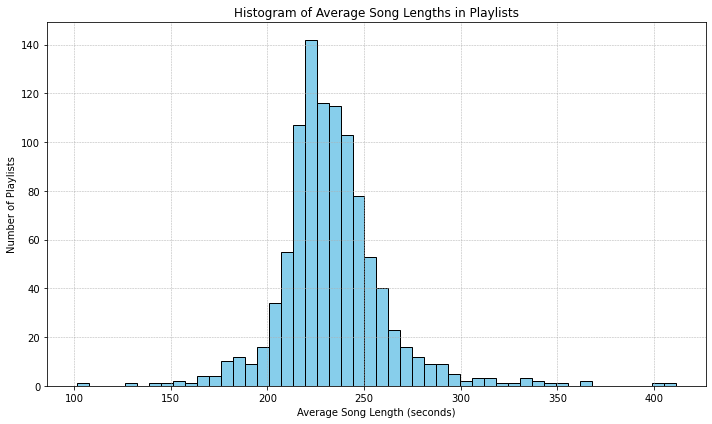

In [5]:
import matplotlib.pyplot as plt

# Plottar medellängden av sånger
plt.figure(figsize=(10, 6))
plt.hist(playlists_df['avg_song_length_ms'] / 1000, bins=50, color='skyblue', edgecolor='black') 
plt.title('Histogram of Average Song Lengths in Playlists')
plt.xlabel('Average Song Length (seconds)')
plt.ylabel('Number of Playlists')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Uppgift 1 - Content-based filtering
____________

In [6]:
# Konkatenerar alla artist namn för varje spellista -> Resultatet är en ny dataframe med "playlist namn" och alla artister
playlists_df['all_artists'] = playlists_df['tracks'].apply(lambda x: ' '.join([track['artist_name'] for track in x]))
playlists_df[['name', 'all_artists']].head()


,name,all_artists
0,Throwbacks,Missy Elliott Britney Spears Beyoncé Justin Ti...
1,Awesome Playlist,Survivor Daniel Tidwell Daniel Tidwell Daniel ...
2,korean,Hoody Loco Park Kyung Park Kyung BTS Lovelyz L...
3,mat,Camille Saint-Saëns Camille Saint-Saëns No Vac...
4,90s,The Smashing Pumpkins Oasis Aerosmith Natalie ...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Startta TF-IDF vektoriseraren med stop words english för att ta bort "the", "and", "is" etc..., max features för att minska matrisen
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Skapar själva matrisen
tfidf_matrix = tfidf_vectorizer.fit_transform(playlists_df['all_artists'])

tfidf_matrix.shape
# print(tfidf_matrix)


(1000, 5000)

#### Här är de 10 mest liknande spellistorna till "Throwbacks" baserat på artistinnehållet:

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Target playlist i detta fall är playlist "0" som heter Throwbacks
target_playlist_index = 0
cosine_similarities = cosine_similarity(tfidf_matrix[target_playlist_index], tfidf_matrix).flatten()

# Top 10 
similar_playlists_indices = cosine_similarities.argsort()[-2:-12:-1]  # -2 för att inte ta med egna playlisten
similar_playlists = playlists_df.iloc[similar_playlists_indices]
similar_playlists[['name', 'all_artists']]


# Svaret verkkar överänsstämma med vett och förnuft, "old songs" andra "Throwbacks" är alla så kallade "Throback" listor
# vilket skulle tyda på att programmet rekommenderar vettigt

,name,all_artists
359,old songs,Akon Taio Cruz Kelis Vanessa Carlton Busta Rhy...
717,Throwbacks,Kardinal Offishall Ray J Jesse McCartney Metro...
908,old but good,Chris Brown Trey Songz Jason Derulo fun. B.o.B...
128,bae,Meghan Trainor Jesse McCartney Kenny Chesney N...
380,Throwbacks,Katy Perry Britney Spears Taio Cruz Fergie Fer...
262,throwback,Avril Lavigne Fountains Of Wayne Jonas Brother...
747,2000s,Snow Patrol Plain White T's Owl City Maroon 5 ...
944,hoe anthems,Beyoncé Beyoncé Cassie The Pussycat Dolls Keli...
38,tb,Sean Kingston Jason Derulo Iyaz Sean Kingston ...
779,00s,Shaggy Destiny's Child Michelle Branch Alicia ...


## Uppgift 1 - Collaborative filtering
_____________

In [9]:
# Ta ut "track" (sång) data samt PID (playlist ID) och associera varje sång med respektive PID
tracks_data = [{'pid': playlist['pid'], **track} for playlist in playlists_data for track in playlist['tracks']]
tracks_df = pd.DataFrame(tracks_data)

# Frekvenstabell för kombinationer av artister och spellistor
freq_table = tracks_df.groupby(['pid', 'artist_name']).size().reset_index(name='freq')
freq_table.head()


,pid,artist_name,freq
0,0,Avril Lavigne,2
1,0,Beyoncé,2
2,0,Bowling For Soup,1
3,0,Boys Like Girls,2
4,0,Britney Spears,1


In [10]:
# Vi tar en såkallad subset för att minska mängden spellistor programmet kör egenom
# obs! Detta skapar ett mindre pålitligt resultat men resulterar i snabbare program körning
subset_playlists_data = playlists_data[:100]

# Samma som i tidiager block bara att för subsetten
subset_tracks_data = [{'pid': playlist['pid'], **track} for playlist in subset_playlists_data for track in playlist['tracks']]
subset_tracks_df = pd.DataFrame(subset_tracks_data)


subset_freq_table = subset_tracks_df.groupby(['pid', 'artist_name']).size().reset_index(name='freq')

# Användar-item matris
subset_user_item_matrix = subset_freq_table.pivot(index='pid', columns='artist_name', values='freq').fillna(0)

# Likhets matris på basis av hur lik en artist är jämfört med alla andra
subset_item_similarity = cosine_similarity(subset_user_item_matrix.T)
subset_item_similarity_df = pd.DataFrame(subset_item_similarity, index=subset_user_item_matrix.columns, columns=subset_user_item_matrix.columns)

# Funktionen för att få själva rekommendationen (num_recommendations ändrar mängden rekommendationer)
def get_subset_artist_recommendations(pid, num_recommendations=5):

    # Få artister ut ur playlisten
    artists_in_playlist = subset_user_item_matrix.loc[pid]
    artists_in_playlist = artists_in_playlist[artists_in_playlist > 0].index.tolist()
    
    # Beräkna en vägd summa av likhets "score" för alla artister i spellistan
    sim_scores = subset_item_similarity_df[artists_in_playlist].mean(axis=1)
    
    # Sortera artister och filtrera ut artister som redan befinner sig i spellistan
    recommended_artists = sim_scores.sort_values(ascending=False).index.tolist()
    recommended_artists = [artist for artist in recommended_artists if artist not in artists_in_playlist]
    
    return recommended_artists[:num_recommendations]

# Testa funktionen, ändra pid- för att ändra spellistan som resultatet baserar sig på.
# Du kan kolla mpd.slice filen för att kolla fram olika spellistor.
# EXEMPEL: pid-0 = "Throwbacks", pid-88 = "KPOP", pid-61 = "Country"
# Resultaten verkar pålitliga och bra på basis av vår analys av olika spellistor
subset_recommendations_test = get_subset_artist_recommendations(0)
subset_recommendations_test

['Rihanna', 'Gwen Stefani', 'Maroon 5', 'Alicia Keys', 'Neil Diamond']

## Uppgift 2 - Hybrid recommendation system
________________

In [25]:
def hybrid_recommendation(pid, num_recommendations=5):

    # 1. Content-based rekommendation
    cosine_similarities = cosine_similarity(tfidf_matrix[pid], tfidf_matrix).flatten()
    similar_playlists_indices = cosine_similarities.argsort()[-2:-12:-1] 

    # 2. Collaborative filtering rekommendation
    all_recommendations = []
    for index in similar_playlists_indices:
        # Se till att spellistans ID är i subsetten
        if index in subset_user_item_matrix.index:
            recommendations = get_subset_artist_recommendations(index, num_recommendations)
            all_recommendations.extend(recommendations)

    # 3. Sammanställ artist rekommendationer
    recommended_artists = pd.Series(all_recommendations).value_counts().index.tolist()

    return recommended_artists[:num_recommendations]

# Testa funktionen, ändra pid- för att ändra spellistan som resultatet baserar sig på.
# Du kan kolla mpd.slice filen för att kolla fram olika spellistor.
# EXEMPEL: pid-0 = "Throwbacks", pid-88 = "KPOP", pid-61 = "Country"
# Resultaten verkar pålitliga och bra på basis av vår analys av olika spellistor
hybrid_recommendations = hybrid_recommendation(88)
hybrid_recommendations

NameError: name 'subset_user_item_matrix' is not defined

## Källor
____________________

OpenAI. (2023). Code Generated by ChatGPT (3.5/4.0) [Code]. 
Notis. ChatGPT användes i arbetet för att speglas med och producera kod som resulterade i ett förbättrat
program vilket inte skulle ha varit möjligt utan AI stöd. 
